## Licensee Event Report Classification

### TL;DR
My project is to build a model to classify documents into 16 categories. Each document can have multiple categories. The documents are scanned pdfs, so gathering the documents and extracting and cleaining the text took up most of the project time. The goal (business objective) is not to build a model with 100% accuracy, but to narrow the documents that need to be reviewed by a person to be categorized.

### Background
Certain events that occur at nuclear power reactor facilities are required to be reported by the facility license holders to the U.S. Nuclear Regulatory Commission (NRC). One of the reporting mechanisms is known as the Licensee Event Reporting (LER) System. Licensees submit the report to the U.S. NRC within 60 days of the event, either online or through the mail. In either case, the report is submitted using a standard NRC form, and ends up as a PDF in the agency's document management system as well as a dedicated LER search database. Each report is given a unique number, and occasionally licensees submit revisions to these reports that provide additional information.

The purpose of these reports is for the agency staff to evaluate them and determine if any agency actions are warranted, and to communicate any lessons learned from the events to the industry. There is a dedicated team of engineers at the agency that review every report (and other sources of information not within the scope of this project) to determine which category (subject matter) the reports belong to, and hence which experts in the agency should review the report. The members of this team use their experience and engineering judgement to determine what categories each report belongs to, so there is some variability depending on which member reviews a report. Each report may have multiple categories assigned to them by the reviewer. Once the report is tagged with the categories, the technical expert(s) for each subject matter recieves a notification email that they have a new item to review in the agency's tracking database. Examples of categories include Pump and Valves, Electrical Power Systems, Human Performance, and Emergency Diesel Generators.

### Objectives
The objective of this project is to build a model or models to classify these reports into the categories. The ultimate business objective would be to reduce the amount of reports that the team of reviewers need to see, so they can dedicate more time elsewhere.

### Source Data
The LERs are available in PDF format in the Agencywide Document Accession and Management System (<a href = "https://adams.nrc.gov/wba/">ADAMS</a>) or the agency's <a href="https://lersearch.inl.gov/LERSearchCriteria.aspx">LER Search</a>. For this project, I decided to focus on using the report abstract section rather than the entire report text, since they typically contain enough information to classify the document. Cleaning the data posed several unique challenges, and took up the majority of the time in this project. Rather than provide all of the actual PDF data, I will explain how I addressed each of these challenges and provide the functions I used, as well as an example file so that the abstract extraction process can be replicated. In order to replicate the data, you have to download each PDF from either ADAMS or the LER Search linked above.

### Challenges with the PDF data
The first challenge is that the reports are typically submitted with a cover sheet, and some reports have several pages prepended before the actual report we are interested in. For example, this <a href="https://lersearch.inl.gov/PDFView.ashx?DOC::2592017001R00.PDF">report</a> actually starts on the third page. To find the first page, I used PyPDF2 to extract the text for each page, and search the text for certain keywords (e.g., Abstract or 366). If the page contained these keywords, it is very likely to be the first page. There were several reports that were submitted at the same time and are in the same PDF, so some manual fixed were necessary to split those files up.

The next challenge was to remove some of the extraneous boilerplate text from the top of the first page and obtain only the abstract of the report. I accomplished this by using pdfminer.six to extract each horizontal text line with their coordinates, as well as the dimensions of each page in order to calculate the relative coordinates of the start of the abstract area. To get the target area, I searched for lines that contain the word "ABSTRACT" (I used a regular expression because sometimes ABSTRACT shows up slightly misspelled), and gathered the text with vertical coordinates below that. Some documents did not contain "ABSTRACT". In those cases, I used the average abstract relative coordinates and used the text below those coordinates.

Finally, PDF quality varies in the source data, so there are several low-quality PDF documents. These low quality PDFs make extracting the abstract difficult and would provide little value to the model. To address this, I created a function to determine the ratio of misspelled words to total words in the document. If that ratio is greater than a certain threshold, then the LER will not be used.

### Target Data
The target/response data was obtained from the agency's internal database that is used to track what actions are taken for each event report. This database has the capability to export the data to Excel format. Initially, I had issues with obtaining training data to the point that it was becoming its own machine learning problem. The migration to a new database caused the loss of the numbering of the reports, so I only had the title of each report and the categories.  I needed the report numbers to be able to obtain the reports themselves. I had a separate list of report numbers and titles, but the titles in the database were sometimes changed by the reviewer to add more information (and there are occassionally duplicate titles).  I matched the titles using document similarities and dates, which worked reasonably well, but still required manual verification. I got lucky and was eventually able to obtain the data from the old database.  Basically, the data that I exported has the LER number, and the categories that were assigned to that LER. For convenience, I created an Excel file with all of the data used in the project.

## Function for getting report start page

In [1]:
import re
import PyPDF2

abstract_re = re.compile('(ABSTRACT)|(.*?STRAC.*)')
abstract_re = re.compile('.*?STRAC.*')

def get_start_page(filepath):
    """Takes in a filepath to an LER PDF and returns the start page number,
    raises a ValueError if it doesn't find it."""
    start_page = -1
    with open(filepath, 'rb') as file:
        pdf = PyPDF2.PdfFileReader(file)
        for page_num in range(pdf.getNumPages()):
            page = pdf.getPage(page_num)
            text = page.extractText()
            if abstract_re.search(text):
                return page_num
    raise ValueError

## Function for getting text lines

In [2]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
import pdfminer


def get_lines(filepath):
    """Takes in a filepath to an LER PDF and returns the text for each line
    with coordinates"""
    start_page = get_start_page(filepath)
    file = open(filepath, 'rb')
    # Create a PDF parser object associated with the file object.
    parser = PDFParser(file)

    # Create a PDF document object that stores the document structure.
    document = PDFDocument(parser)
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed
    rsrcmgr = PDFResourceManager()

    # Create a PDF device object.
    device = PDFDevice(rsrcmgr)

    # BEGIN LAYOUT ANALYSIS
    # Set parameters for analysis.
    laparams = LAParams()

    # Create a PDF page aggregator object.
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)

    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # Get target page
    page = list(PDFPage.create_pages(document))[start_page]

    interpreter.process_page(page)
    layout = device.get_result()

    lines = [[obj.get_text(), (obj.bbox)] for obj in layout._objs if isinstance(obj, pdfminer.layout.LTTextBoxHorizontal)]
    return lines

## Function for getting start of abstract

In [3]:
def get_abstract(filepath):
    """Takes in a path to an LER PDF file and returns the abstract"""
    lines = get_lines(filepath)
    start_coordinates = [line for line in lines if abstract_re.search(line[0])][0][-1]
    
    # We're interested in text lines that have a Y coordinate less than start_coordinates[1]
    abstract_lines = [line for line in lines if line[-1][1] <= start_coordinates[1]]
    abstract_lines = sorted(abstract_lines, key=lambda x: -x[-1][1]) # Sort by descending Y coordinates
    text = '\n'.join([line[0] for line in abstract_lines])
    
    # Clean up some more boilerplate, including the boilerplate ABSTRACT statement 
    # and page number at bottom of the report
    text = re.sub('.*?STRAC.*', '', text)
    start = list(re.finditer('1[45]\..*', text))
    if start:
        start = start[-1]
        text = text[start.span()[1]:]
    # Remove NRC FORM 366 at the bottom of the page
    nrc_form = re.search('NR[CG]\sFORM\s+366', text)
    if nrc_form:
        text = text[:nrc_form.span()[0]]
    # Remove double spaces
    text = re.sub('[ ]+', ' ', text).strip()
    return text

## Function for getting misspelling ratio

In [4]:
from spellchecker import SpellChecker
import nltk

# Instantiate SpellChecker
spell = SpellChecker()


def tokenize(text):
    """Function to tokenize words."""
    return nltk.tokenize.word_tokenize(text.lower())
    

def misspelled_ratio(text):
    """Function takes in text, tokenizes it into words
    and returns a ratio of misspelled words in text."""
    words = tokenize(text)
    misspelled = spell.unknown(words)
    return len(misspelled) / len(words)

## Example of getting the abstract text

In [5]:
filepath = 'data/4582011002R00.pdf'
abstract = get_abstract(filepath)
print(abstract)
print('\nMisspelled Ratio:')
print(misspelled_ratio(abstract))

On February 13, 2011, at approximately 5:00 a.m. CST, during power ascent following a refueling outage, 
operators found that one channel of main turbine first stage pressure instrumentation was not responding to 
changing plant parameters. This instrument provides a permissive to the reactor protection system (RPS) to 
enable a reactor scram signal from main turbine control valve control valve fast closure and main turbine stop 
valve closure. Also enabled by that permissive is a reactor recirculation pump trip signal initiated by the main 
turbine stop valve closure. While performing the initial troubleshooting, a maintenance technician discovered that 
a valve at the affected steam pressure transmitter was closed, isolating it from the system. This valve had 
apparently been left closed following the calibration of the instrument during the outage. The valve was opened, 
and the instrumentation channel was declared operable at 5:52 p.m. that day. The signals enabled by this 
pressur

## Importing the data

In [6]:
%matplotlib inline

# Import pandas and numpy libraries
import numpy as np
import pandas as pd

# Read in the data
df = pd.read_excel('data/Public Data.xlsx')
df.shape

(2970, 9)

In [7]:
df.head()

,Issue ID,TRG,LER Number,Title,Text,Abstract Text,Abstract Misspelling Ratio,Text Misspelling Ratio,Availability
0,5,HVAC/DOSE,3252009001R0,Loss of Control Room Air Conditioning and Emer...,l \n\n1 •. \n\nNRC FORM 366 \n(9-2007) \n\n.) ...,"On January 21, 2009, at approximately 1300 hou...",0.046595,0.026290,Publicly Available
1,6,"FIRE PROTECTION, HUMAN PERF/SAFETY CULTURE",3132009002R0,Manual Reactor Trip From Power in Response to ...,\n\n \n\n2 \n\n7 \n\n \n9. OPERATING MODE \n\...,"On February 7, 2009, at approximately 1046 CST...",0.003846,0.018164,Publicly Available
2,43,CONTAINMENT,2932009002R0,Failure to Meet Technical Specification Requir...,NRC Form 366 \n(9-2007) \n\nU.S. NUCLEAR REGUL...,"On December 22, 2009, at 0845 hours, with the ...",0.015209,0.023145,Publicly Available
3,44,"CONTAINMENT, HUMAN PERF/SAFETY CULTURE",3362009005R0,Both Containment Air Lock Doors Open in Mode 1,NRC FORM 361) \n(9-2007) \n\nU.S. NUCLEAR REGU...,"On November 13, 2009, with Millstone Power Sta...",0.008097,0.055246,Publicly Available
4,45,SERVICE WATER/UHS,3612009004R0,Both Trains of Spent Fuel Pool Cooling Inopera...,NRC FORM 366 \n(9-2007) \n\nU.S. NUCLEAR REGU...,On 12/23/2009 at about 0957 PST with Unit 2 de...,0.018727,0.027870,Publicly Available


In [8]:
# Remove rows where misspelling ratio is > 0.1
df = df[df['Abstract Misspelling Ratio'] <= 0.1]
df = df[df['Abstract Text'].notnull()]
df.shape

(2968, 9)

## Import libraries

In [9]:
import scipy
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt


## Transform response column using MultilabelBinarizer

In [10]:
# Transform the response column (TRG) to a matrix
mlb = MultiLabelBinarizer()
y_df = mlb.fit_transform(df['TRG'].apply(lambda t: t.split(', ')))
y_df = pd.DataFrame(y_df, columns = mlb.classes_)
y_df.sum() # Class Counts

AFW                           150
CHEM/CHEM ENG                  18
CONTAINMENT                   352
CYBER SECURITY                  1
ECCS                          424
EDG                           182
ELECTRICAL PWR                715
ENVTL. QUALIF.                 70
EP                             26
FIRE PROTECTION               160
FLOODING/MISSILES             128
FUELS                          16
HEALTH PHYSICS                 23
HUMAN PERF/SAFETY CULTURE    1016
HVAC/DOSE                     269
I&C                           583
NRO                           310
OTHER                         752
PHYS SECURITY                  29
PRI MAT'L/VSL/WELD            179
PUMP & VALVE                  541
PWR UPRATE                     13
QA/VENDOR/CFSI                253
SAFETY CULTURE                 51
SERVICE WATER/UHS             173
SG                             10
SPENT FUEL HANDL.              26
STRUCTURAL/CONCRETE            44
dtype: int64

In [11]:
# Lets just focus on classes with more than 100 samples, and remove amiguous class OTHER
classes = list(y_df.sum()[y_df.sum() > 100].index)
classes.remove('OTHER')
y_df = y_df[classes]
y_df.sum()

AFW                           150
CONTAINMENT                   352
ECCS                          424
EDG                           182
ELECTRICAL PWR                715
FIRE PROTECTION               160
FLOODING/MISSILES             128
HUMAN PERF/SAFETY CULTURE    1016
HVAC/DOSE                     269
I&C                           583
NRO                           310
PRI MAT'L/VSL/WELD            179
PUMP & VALVE                  541
QA/VENDOR/CFSI                253
SERVICE WATER/UHS             173
dtype: int64

## Let's examine the first category

In [12]:
# Try with class: AFW
cls = 'AFW'
y = y_df[cls]
X = df['Abstract Text']
title = df['Title']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [13]:
# Null accuracy
def null_accuracy(cls):
    most_freq_class = y_df[cls].value_counts().idxmax() # Probably overkill, since it is pretty much always 0
    y_pred = most_freq_class * np.ones(y_df[cls].shape) # Predict all values are most_freq_class
    return metrics.accuracy_score(y_pred, y_df[cls])


print(f'Null Accuracy: {null_accuracy(cls)}')
y_pred = mnb.predict(X_test_tfidf)
print(f'MNB Accuracy : {metrics.accuracy_score(y_test, y_pred)}')

Null Accuracy: 0.9494609164420486
MNB Accuracy : 0.9568733153638814


So for this category, Multinomial Naive Bayes has about the same accuracy score as the null accuracy. I'll use a different evaluation metric later on. Let's check out the confusion matrix to see what type of errors the model makes, and then see how MNB performs on the other categories.

In [14]:
metrics.confusion_matrix(y_test, y_pred)

array([[696,   2],
       [ 30,  14]], dtype=int64)

### Using MultinomialNB on all of the categories

In [26]:
# Instantiate tfidf and fit X
tfidf = TfidfVectorizer(stop_words='english')
X = df['Abstract Text']
X_train, X_test, y_train, y_test = train_test_split(X, y_df, random_state=42)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Instantiate MNB model
mnb = MultinomialNB()
results = []
for cls in y_df.columns:
    # Only get the response column we are interest in
    y_trn = y_train[cls]
    y_tst = y_test[cls]
    
    # Fit the model
    mnb.fit(X_train_tfidf, y_trn)
    
    # Predict
    y_pred = mnb.predict(X_test_tfidf)
    
    # Get scores
    score = metrics.accuracy_score(y_tst, y_pred)
    null_acc = null_accuracy(cls)
    results.append([cls, null_acc, score])

results = pd.DataFrame(results, columns=['Class', 'Null Accuracy', 'MNBScore'])
results['ClassCounts'] = results['Class'].map(y_df.sum())
results

,Class,Null Accuracy,MNBScore,ClassCounts
0,AFW,0.949461,0.940701,150
1,CONTAINMENT,0.881402,0.894879,352
2,ECCS,0.857143,0.836927,424
3,EDG,0.938679,0.956873,182
4,ELECTRICAL PWR,0.759097,0.808625,715
5,FIRE PROTECTION,0.946092,0.955526,160
6,FLOODING/MISSILES,0.956873,0.958221,128
7,HUMAN PERF/SAFETY CULTURE,0.657682,0.691375,1016
8,HVAC/DOSE,0.909367,0.896226,269
9,I&C,0.803571,0.815364,583


#### Note: We could have done the same as above with a OneVsRestClassifier:

In [28]:
# Using OneVsRestClassifier, which supports multilabel classification
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB())),
            ])

NB_pipeline.fit(X_train, y_train)
y_pred = NB_pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_df.columns)
results = pd.DataFrame([
                        [cls, null_accuracy(cls), metrics.accuracy_score(y_pred[cls], y_test[cls])] 
                         for cls in y_pred.columns
                       ],
                       columns=['Class', 'Null Accuracy', 'MNBScore'])
results['ClassCounts'] = results['Class'].map(y_df.sum())
results

,Class,Null Accuracy,MNBScore,ClassCounts
0,AFW,0.949461,0.940701,150
1,CONTAINMENT,0.881402,0.894879,352
2,ECCS,0.857143,0.836927,424
3,EDG,0.938679,0.956873,182
4,ELECTRICAL PWR,0.759097,0.808625,715
5,FIRE PROTECTION,0.946092,0.955526,160
6,FLOODING/MISSILES,0.956873,0.958221,128
7,HUMAN PERF/SAFETY CULTURE,0.657682,0.691375,1016
8,HVAC/DOSE,0.909367,0.896226,269
9,I&C,0.803571,0.815364,583


In [29]:
y_pred = pd.DataFrame(y_pred, columns=y_df.columns)

# For one class
print(metrics.accuracy_score(y_test['AFW'], y_pred['AFW']))

0.9407008086253369


### Evaluation Metrics: AUC
Accuracy score can only tell us how many predictions are correct, but it does not tell us about the types of errors that our model is making. Additionally, if there are a lot of negative samples (i.e., y = 0) then accuracy can lead to inappropriate interpretation of the performance of our model. This is especially the case for some of the more infrequent categories.

The type of error is important to our business objective because if we have too many false negatives, then the document would not be seen by the appropriate people that need to see it.  On the other hand, if we predict too many false positives, then those people might get spammed with irrelevant documents.

I will use Area Under the Reciever Operating Characteristic curve (AUROC or AUC) as the evaluation metric, since this tells us more about what types of errors our model is making. I will define a function that calculates the AOC (estimated for a testing set) and plots the ROC.

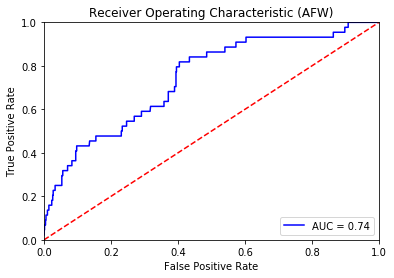

In [30]:
mnb.fit(X_train_tfidf, y_train['AFW'])
y_pred_proba = mnb.predict_proba(X_test_tfidf)
preds = y_pred_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test['AFW'], preds)
roc_auc = metrics.auc(fpr, tpr)
title = 'Receiver Operating Characteristic (AFW)'
plt.title(title)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

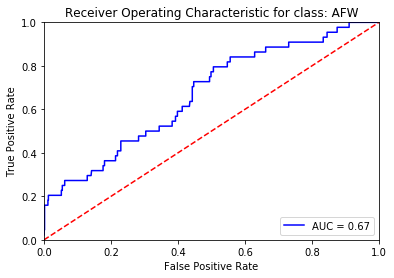

In [35]:
def plot_roc(classifier, X, y, class_name='AFW', random_state=42):
    """Function to calculate the AUC and plot the ROC of a mode.
    Parameters
    -----------
    classifier: required
        The actual model we are evaluating
    X: Array-like, required
        The input features
    y: Array-like, required
        The responses (target)
    class_name: str, optional
        The name of the class we are training on
    random_state: int, optional
        Random seed for train_test_split
    """
    y = y[class_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    try:
        classifier.fit(X_train, y_train)
    except ValueError: # classifier does not have a document transformer (e.g., TfidfVectorizer, CountVectorizer)
        tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
        X_train = tfidf.fit_transform(X_train)
        X_test = tfidf.transform(X_test)
        classifier.fit(X_train, y_train)
    y_pred_proba = classifier.predict_proba(X_test)
    preds = y_pred_proba[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    title = 'Receiver Operating Characteristic'
    if class_name is not None:
        title += ' for class: ' + class_name
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

class_name = 'AFW'
auc = plot_roc(MultinomialNB(), X, y_df, class_name=class_name)

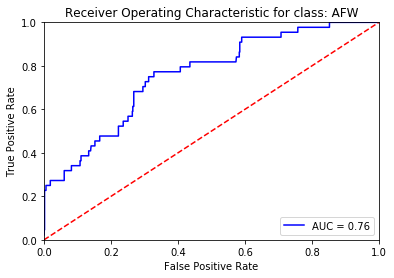

In [36]:
# Let's try with another value for alpha
auc = plot_roc(MultinomialNB(alpha=0.2), X, y_df, class_name=class_name)

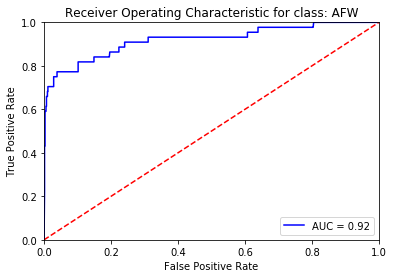

In [40]:
auc = plot_roc(MultinomialNB(alpha=0.01), X, y_df, class_name=class_name)

In [41]:
def confusion_matrix(y_true, y_pred):
    """A helper function to get the confusion matrix as a DataFrame,
       to make it easier to print and read."""
    return pd.DataFrame(metrics.confusion_matrix(y_true, y_pred),
                        columns=['Predicted: 0', 'Predicted: 1'], 
                        index=['Actual: 0', 'Actual: 1'])

In [42]:
X = df['Abstract Text']
y = y_df['AFW']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
confusion_matrix(y_test, y_pred)

,Predicted: 0,Predicted: 1
Actual: 0,697,1
Actual: 1,30,14


In [43]:
pipe = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB(alpha=0.01))
scores = cross_val_score(pipe, df['Abstract Text'], y_df['AFW'], cv=10, scoring='roc_auc')
print("AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC: 0.93 (+/- 0.11)


### SVC with linear kernel vs. LinearSVC
Let's confirm that they are the same. We need SVC(kernel='linear') so we can get probabilities to be able to calculate the AUC

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df['Abstract Text'], y_df['AFW'], random_state=42)
pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(1, 3)), LinearSVC())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
confusion_matrix(y_test, y_pred)

,Predicted: 0,Predicted: 1
Actual: 0,697,1
Actual: 1,23,21


In [45]:
X_train, X_test, y_train, y_test = train_test_split(df['Abstract Text'], y_df['AFW'], random_state=42)
pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(1, 3)), SVC(kernel='linear'))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
confusion_matrix(y_test, y_pred)

,Predicted: 0,Predicted: 1
Actual: 0,697,1
Actual: 1,23,21


### SVC(kernel='linear') ROC

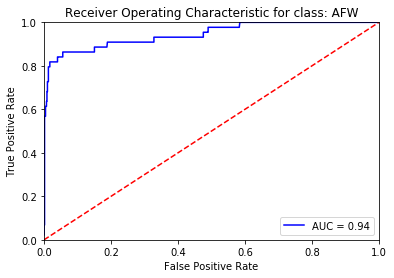

In [46]:
auc = plot_roc(SVC(kernel='linear', probability=True), X=df['Abstract Text'], y=y_df, class_name='AFW')

In [47]:
%%time
pipe = make_pipeline(TfidfVectorizer(stop_words='english'), SVC(kernel='linear', probability=True))
scores = cross_val_score(pipe, df['Abstract Text'], y_df['AFW'], cv=10, scoring='roc_auc')
print("AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC: 0.92 (+/- 0.14)
Wall time: 3min 17s


### MultinomialNB hyperparameter tuning with RandomizedSearchCV

In [27]:
%%time

# create a pipeline
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()),
                 ('multinomialnb', MultinomialNB())
                ])

# search for an optimal parameter using RandomizedSearchCV
# TFIDF params
ngram_ranges = [(1, 1), (1, 2), (1, 3), (1, 4)]
norm_options = [None,'l1', 'l2']
stopword_options = [None, 'english']

# MultinomialNB params
alpha_options = np.linspace(0.0, 1.0, 21)


#create a param dist
param_dist = dict(tfidfvectorizer__ngram_range=ngram_ranges, tfidfvectorizer__norm=norm_options,
                  tfidfvectorizer__stop_words=stopword_options, multinomialnb__alpha=alpha_options)

# create a radomizedgrid search
rand_mnb = RandomizedSearchCV(pipe, param_dist, cv=10, scoring='roc_auc',
                          n_iter=10, random_state=5, return_train_score=True)
X = df['Abstract Text']
y = y_df['AFW']
rand_mnb.fit(X, y)
# examine the best model
print(rand_mnb.best_score_)
print(rand_mnb.best_params_)

0.9023984590586099
{'tfidfvectorizer__stop_words': 'english', 'tfidfvectorizer__norm': None, 'tfidfvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 1.0}
Wall time: 3min 43s


In [28]:
# Now let's take a look at the confusion matrix
mnb = rand_mnb.best_estimator_
y_pred = mnb.predict(df['Abstract Text'])
confusion_matrix(y_df['AFW'], y_pred)

,Predicted: 0,Predicted: 1
Actual: 0,2803,15
Actual: 1,0,150


In [29]:
# Let's examine the false positives
X.iloc[np.where(y_pred != y_df['AFW'])[0]].values

array(['At 1415 Central Daylight Time (CDT) on July 24, 2009, with Unit 1 in Mode 1, at approximately 100 percent of rated thermal power, Operations was conducting a surveillance on the High Pressure Coolant Injection System (HPCI), 1-SR-3.5.1.7, "HPCI Main and Booster Pump Set Development Head and Flow Rate Test at Rated Reactor Pressure." At approximately 1415 CDT, during the prerequisite steps 1-PCV-073-0018C, the HPCI Turbine Stop Valve Mechanical Trip Hold Valve developed a tear in the diaphragm. This tear caused oil from the HPCI control oil system to spill at a rate of approximately 0.25 to 0.5 gallons per minute (gpm). The pressurization of the control oil system is the motive force required to open the HPCI stop valve. If the oil system could not be pressurized the HPCI Stop Valve could not be opened which would render HPCI inoperable.  The root cause was a material defect in the diaphragm of 1-PCV-073-0018C, HPCI Turbine Stop Valve Mechanical Trip Hold Valve, allowed the diap

This seems like a reasonable model. It predicts a few of the negative samples as positive. This means that and expert would review a few irrelevant reports, but would not miss many relevant reports. We can live with that from a business objective perspective.

### SVC(kernel='linear') hyperparameter tuning with RandomizedSearchCV

In [30]:
%%time

# create a pipeline
pipe = Pipeline([
                 ('tfidfvectorizer', TfidfVectorizer()),
                 ('svc', SVC(kernel='linear', probability=True))
                ])

# TFIDF params
ngram_ranges = [(1, 1), (1, 2), (1, 3), (1, 4)]
norm_options = [None,'l1', 'l2']
stopword_options = [None, 'english']

# SVC params
C_options = np.linspace(0.0, 1.0, 21)

#create a param dist
param_dist = dict(tfidfvectorizer__ngram_range=ngram_ranges, tfidfvectorizer__norm=norm_options,
                  tfidfvectorizer__stop_words=stopword_options, svc__C=C_options)

rand_svc = RandomizedSearchCV(pipe, param_dist, cv=10, scoring='roc_auc',
                          n_iter=10, random_state=5, return_train_score=True)

y = y_df['AFW']
rand_svc.fit(X, y)

# examine the best model
print(rand_svc.best_score_)
print(rand_svc.best_params_)

0.9245649751748218
{'tfidfvectorizer__stop_words': 'english', 'tfidfvectorizer__norm': None, 'tfidfvectorizer__ngram_range': (1, 3), 'svc__C': 0.75}
Wall time: 10min 55s


In [31]:
# Now let's take a look at the confusion matrix
svc = rand_svc.best_estimator_
y_pred = svc.predict(df['Abstract Text'])
confusion_matrix(metrics.confusion_matrix(y_df['AFW'], y_pred))

,Predicted: 0,Predicted: 1
Actual: 0,2817,1
Actual: 1,8,142


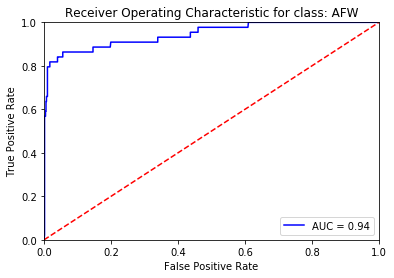

In [33]:
pipe = Pipeline([
                 ('tfidfvectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1, 3))),
                 ('svc', SVC(kernel='linear', probability=True, C=0.75))
                ])
auc = plot_roc(pipe, df['Abstract Text'], y_df, class_name='AFW')

### Other features
The data also has the report titles and full (uncleaned) pdf text. From experience, I can also tell that some keywords might be important to some of the documents, so I'll see if adding a feature indicating the presence of these keywords in the document would be useful.

#### Title

In [74]:
%%time
# First, I'll try using the title

# create a pipeline
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()),
                 ('multinomialnb', MultinomialNB())
                ])

# search for an optimal parameter using RandomizedSearchCV
# TFIDF params
ngram_ranges = [(1, 1), (1, 2), (1, 3), (1, 4)]
norm_options = [None,'l1', 'l2']
stopword_options = [None, 'english']

# MultinomialNB params
alpha_options = np.linspace(0.0, 1.0, 21)


#create a param dist
param_dist = dict(tfidfvectorizer__ngram_range=ngram_ranges, tfidfvectorizer__norm=norm_options,
                  tfidfvectorizer__stop_words=stopword_options, multinomialnb__alpha=alpha_options)

# create a radomizedgrid search
rand_mnb = RandomizedSearchCV(pipe, param_dist, cv=10, scoring='roc_auc',
                          n_iter=10, random_state=5, return_train_score=True)
X = df['Title']
y = y_df['AFW']
rand_mnb.fit(X, y)
# examine the best model
print(rand_mnb.best_score_)
print(rand_mnb.best_params_)

0.8553570722759872
{'tfidfvectorizer__stop_words': 'english', 'tfidfvectorizer__norm': None, 'tfidfvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 1.0}
Wall time: 12 s


In [75]:
mnb = rand_mnb.best_estimator_
y_pred = mnb.predict(df['Title'])
confusion_matrix(y_df['AFW'], y_pred)

,Predicted: 0,Predicted: 1
Actual: 0,2730,88
Actual: 1,4,146


#### Full report text
Now I'll try the full text

In [76]:
# First, I'll remove reports with high misspelling ratios
full_text = df[df['Text Misspelling Ratio'] < 0.1]

# Transform the response column (TRG) to a matrix
mlb = MultiLabelBinarizer()
y_df_ft = mlb.fit_transform(full_text['TRG'].apply(lambda t: t.split(', ')))
y_df_ft = pd.DataFrame(y_df_ft, columns = mlb.classes_)
y_df_ft.sum() # Class Counts
classes = list(y_df_ft.sum()[y_df_ft.sum() > 100].index)
classes.remove('OTHER')
y_df_ft = y_df_ft[classes]
y_df_ft.sum()

AFW                           150
CONTAINMENT                   347
ECCS                          420
EDG                           181
ELECTRICAL PWR                713
FIRE PROTECTION               159
FLOODING/MISSILES             127
HUMAN PERF/SAFETY CULTURE    1012
HVAC/DOSE                     267
I&C                           573
NRO                           308
PRI MAT'L/VSL/WELD            178
PUMP & VALVE                  536
QA/VENDOR/CFSI                252
SERVICE WATER/UHS             172
dtype: int64

In [78]:
%%time
# First, I'll try using the title

# create a pipeline
pipe = Pipeline([('tfidfvectorizer', TfidfVectorizer()),
                 ('multinomialnb', MultinomialNB())
                ])

# search for an optimal parameter using RandomizedSearchCV
# TFIDF params
ngram_ranges = [(1, 1), (1, 2), (1, 3), (1, 4)]
norm_options = [None,'l1', 'l2']
stopword_options = [None, 'english']

# MultinomialNB params
alpha_options = np.linspace(0.0, 1.0, 21)


#create a param dist
param_dist = dict(tfidfvectorizer__ngram_range=ngram_ranges, tfidfvectorizer__norm=norm_options,
                  tfidfvectorizer__stop_words=stopword_options, multinomialnb__alpha=alpha_options)

# create a radomizedgrid search
rand_mnb = RandomizedSearchCV(pipe, param_dist, cv=10, scoring='roc_auc',
                          n_iter=10, random_state=5, return_train_score=True)
X = full_text['Text']
y = y_df_ft['AFW']
rand_mnb.fit(X, y)
# examine the best model
print(rand_mnb.best_score_)
print(rand_mnb.best_params_)

0.7432473482650714
{'tfidfvectorizer__stop_words': 'english', 'tfidfvectorizer__norm': None, 'tfidfvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 0.75}
Wall time: 38min 45s


### Using FeatureUnion to add other features

In [54]:


class ContainsAFW(BaseEstimator, TransformerMixin):
    """Extracts whether a document contains an AFW keyword,
       and returns a 1 (positive) or 0 (negative)"""
    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        return pd.Series(documents).apply(lambda d: 
                                          int(bool(re.search('(auxiliary feedwater)|(emergency feedwater)|([ae]fw)',
                                                             d, flags=re.IGNORECASE)))).values.reshape(-1,1)

class ContainsKeywords(BaseEstimator, TransformerMixin):
    """Extracts whether a document contains user specified keywords,
       and returns a 1 (positive) or 0 (negative)"""
    def __init__(self, keywords):
        self.keywords = re.compile('|'.join('({})'.format(kw) for kw in keywords), flags=re.IGNORECASE)
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, documents):
        return pd.Series(documents).apply(lambda d: 
                                          int(bool(self.keywords.search(d)))).values.reshape(-1,1)
    
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.
    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [ ]:
keywords = {'AFW': ['auxiliary feedwater', 'emergency feedwater', 'afw', 'efw']
           
           }

In [89]:
pipeline = Pipeline([

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling user keywords
            ('keywords', Pipeline([
                ('selector', ItemSelector(key='Abstract Text')),
                ('feature', ContainsKeywords(['electrical power', 'offsite power', 'electrical bus', 'breaker'])),
            ])),
            
            # Pipeline for pulling LER titles
            ('title', Pipeline([
                ('selector', ItemSelector(key='Title')),
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 3), norm='l2')),
            ])),
            
            # Pipeline for standard bag-of-words model for abstract text
            ('abstract_bow', Pipeline([
                ('selector', ItemSelector(key='Abstract Text')),
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 3), norm='l2')),
                ('best', TruncatedSVD(n_components=100)),
            ])),
            
            # Pipeline for standard bag-of-words model for full text
            ('full_bow', Pipeline([
                ('selector', ItemSelector(key='Text')),
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 3), norm='l2')),
                ('best', TruncatedSVD(n_components=100)),
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'keywords': 0.5,
            'title': 1.5,
            'abstract_bow': 1.5,
            'full_bow': 0.8
        },
    )),

    # Use a SVC classifier on the combined features
#     ('svc', LinearSVC()),
    ('svc', SVC(kernel='linear', probability=True)),
])


In [90]:
X = df.drop('TRG', axis=1)
y = y_df['ELECTRICAL PWR']
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Null Accuracy: {}'.format(null_accuracy('ELECTRICAL PWR')))
print(metrics.accuracy_score(y_test, y_pred))

Null Accuracy: 0.7650485436893204
0.9094437257438551


In [103]:
y_pred_proba = pipeline.predict_proba(X_test)
preds = y_pred_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

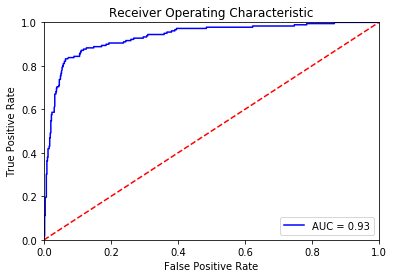

In [104]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [34]:
y_pred = pipeline.predict(X_test)

In [35]:
print(metrics.confusion_matrix(y_test, y_pred))

[[578  12]
 [ 80 103]]


This seems to increase the accuracy of the model

In [15]:
# Now see if titles help the model
X_train, X_test, y_train, y_test = train_test_split(title, y)

In [17]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)
svm = LinearSVC()
svm.fit(X_train_vect, y_train)
y_pred = svm.predict(X_test_vect)
print(metrics.accuracy_score(y_test, y_pred))

0.9728331177231565


In [18]:
metrics.confusion_matrix(y_test, y_pred)

array([[729,   4],
       [ 17,  23]], dtype=int64)